# Energy* search

Energy\* search is an extension of A* which uses potential field based methods to avoid obstacles. Using an online scanning approach, the repulsion forces from neighbouring obstacles of each state opposes the attractive force towards the goal.  By adjusting the relative weights of alpha and beta in the energy functions, different obstacle avoidance behaviour can be achieved.

Because of the obstacle avoidance behaviour, sacrifices in the path costs can be made by using a greedy best-first search approach.  This greatly speeds up time taken to find a valid solution while still maintaining admissibility.

In [1]:
from queue import PriorityQueue
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from grid import get_data, create_grid
from astar import a_star

In [2]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    UP_LEFT = (-1, -1, np.sqrt(2))
    UP_RIGHT = (-1, 1, np.sqrt(2))
    DOWN_LEFT = (1, -1, np.sqrt(2))
    DOWN_RIGHT = (1, 1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        elif self == self.DOWN_RIGHT:
            return '\\'
        elif self == self.DOWN_LEFT:
            return '/'
        elif self == self.UP_RIGHT:
            return '/'
        elif self == self.UP_LEFT:
            return '\\'
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])
    
    def __mul__(self, v):
        return (self.value[0] * v, self.value[1] * v, self.value[2])

def within_bounds(grid, node):
    n, m = grid.shape[0], grid.shape[1]
    x, y = node
    return (x >= 0 and x < n) and (y >= 0 and y < m)
    
def valid_actions(grid, current_node, collision = True):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid_actions = list(Action)
    x, y = current_node

    # check if the node is off the grid or
    # it's an obstacle

    new_actions = list()

    for action in valid_actions:
        x1, y1 = x + action.delta[0], y + action.delta[1]
        if (within_bounds(grid, (x1, y1)) and (not collision or grid[x1, y1] == 0)):
            new_actions.append(action)

    return new_actions

def walkpath(grid, path, start, goal):
    node = (start[0], start[1], 1)
    walked = [np.array(node, dtype=np.float)]
    for i in path:
        node = (node[0] + i[0], node[1] + i[1], 1)
        walked.append(np.array(node, dtype=np.float))
    walked.append(np.array((goal[0], goal[1], 1), dtype=np.float))
    return walked

def visualize_path(grid, path, start):
    sgrid = np.zeros(np.shape(grid), dtype=np.str)
    sgrid[:] = " "
    sgrid[grid[:] == 1] = "O"
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = "G"
    sgrid[start[0], start[1]] = "S" 
    sgrid[grid[:] == 7] = "WP"
    
    output = ""
    for i in range(sgrid.shape[0]):
        output += "["
        for j in range(sgrid.shape[1]):
            output += "{:3}".format(sgrid[i, j])
        output += "]\n"
    
    print(output)

In [57]:
# Prints two grids side by side for comparison
def print_grids(grid1, grid2):
    m1, n1 = grid1.shape
    m2, n2 = grid2.shape
    
    output = ""
    for i in range(m1):
        output += "["
        for j in range(n1):
            output += "{:3d}".format(grid1[i, j])
        output += "]\t\t["
        for j in range(n2):
            output += "{:3d}".format(grid2[i, j])
        output += "]\n"
    print(output)

def print_map(g):
    x = []
    y = []
    m, n = g.shape
    for i in range(m):
        for j in range(n):
            for v in range(g[i,j]):
                x.append(j + 1)
                y.append(((m - (i + 1)) % m) + 1)

    heatmap, xedges, yedges = np.histogram2d(x, y, bins = (n, m))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(1, figsize=(8, 10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(heatmap.T, extent=extent, origin='lower')
    plt.show()

def draw_grid(g, cmap = 'Greys', path = [], start = None, goal = None):
    fig = plt.figure(figsize=(10,10))

    plt.imshow(g, cmap=cmap, origin='lower')

    plt.ylabel('NORTH')
    plt.xlabel('EAST')
    plt.ylim(ymin=0, ymax=g.shape[0])
    plt.xlim(xmin=0, xmax=g.shape[1])
    #plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    
    for i in path:
        plt.scatter(int(i[1]), int(i[0]), c='red')
    
    if not start is None:
        plt.scatter(int(start[1]), int(start[0]), c='blue')
    
    if not goal is None:
        plt.scatter(int(goal[1]), int(goal[0]), c='green')

    plt.show()

In [4]:
#
#start = (0, 0)
#goal = (9, 11)
#grid = np.array([
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
#    [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
#    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#])
#boundary = 2


#start = (1, 0)
#goal = (20, 16)
#grid = np.array([
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
#    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
#    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
#    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
#    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
#    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
#    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
#    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
#    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
#    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
#    [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
#])
#boundary = 4


start = (304, 435)
goal = (10, 730)
data = get_data(skiprows = 3)
grid = create_grid(data, 30, 0) # safety distance zero!
boundary = 20


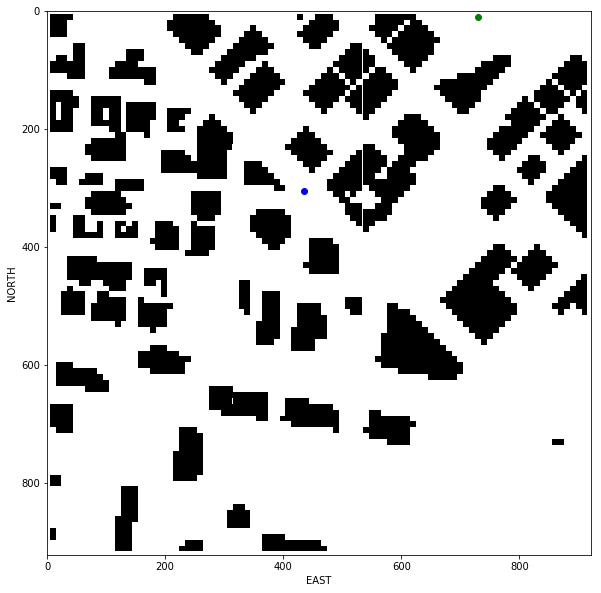

In [5]:
# Print the grid
draw_grid(grid, start = start, goal = goal)

## Attractive Force
The attractive force function determines the $h()$ value for each cell based on the goal cell. The attractive force is a integral of the Euclidean distance between these cells $h= \left((x_i-x_{goal})^2+(y_i-y_{goal})^2\right)^{1/2}$ and the "Manhattan distance", which is the minimum number of moves required to reach the goal from the assigned cell $h = ||x_i-x_{goal}|| + ||y_i-y_{goal}||$. In this approach we have combined the costs of both, taking into the complete space of the environment.

Attraction formula is as follows:
$$F_{att} = \alpha * h(x, x_{goal}) = (||x_i-x_{goal}|| + ||y_i-y_{goal}||) + \left((x_i-x_{goal})^2+(y_i-y_{goal})^2\right)^{1/2}$$

The input variables include
* **```x```** the coordinates of the current state.
* **```x_goal```** the coordinates of the goal cell

In [6]:
# Attractive forces towards the goal
def attractive_force(position, goal_position, alpha = 1.0):
    pos = np.array(position)
    goal = np.array(goal_position)
    # euclidean distance + manhattan
    h = np.linalg.norm(pos - goal) + np.sum(np.abs(pos - goal))
    return alpha * h

### Visualise the attractive energy field
Show the repulsive energy field of the grid world.

In [7]:
grida = np.zeros_like(grid)

for i in range(len(grid)):
    for j in range(len(grid[0])):
        grida[i, j] = attractive_force((i, j), goal)

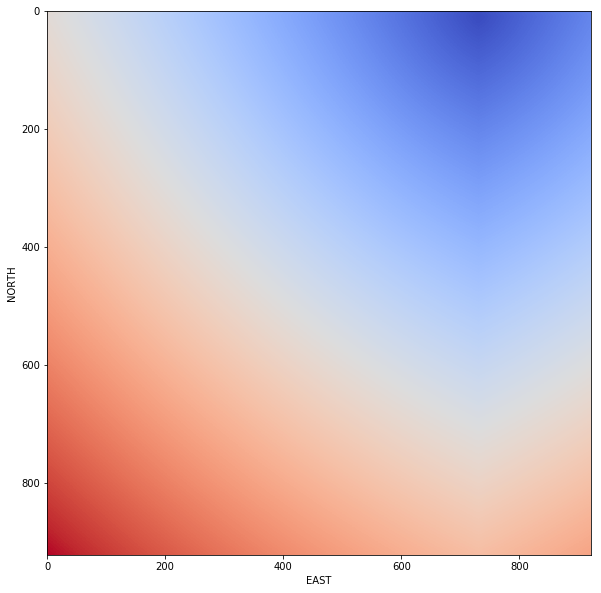

In [8]:
draw_grid(grida, cmap='coolwarm')

## Repulsive Force
The repulsive force function determines the $r()$ value for each cell based on its nearest neighbours. The repulsive force value is the combined sum of the scaled force values for each state.  The repulsion potential energy is only computed when the state's nearest obstacle is $d(x - x_{obs}) < Q_{max}$:

Repulsion formula is given by:
$$F_{rep} = \beta * (\frac{1}{Q_{max}} - \frac{1}{d(x - x_{obs})}) * \frac{1}{d(x - x_{obs})^2}$$

where $x_{obs}$ is the obstacle location and $d(...)$ is the distance metric.

Where
* **```x```** is the coordinates of the current state.
* **```x_obs```** the coordinates of the nearest obstacle

In [9]:
# Repulsive forces away from obstacles
def repulsive_force(grid, current_node, boundary = 4, beta = 5.0):
    actions = valid_actions(grid, current_node, collision = False)

    force = 0
    for i in range(boundary):
        depth = boundary - i
        for a in actions:
            next_node = (current_node[0] + a.delta[0] * depth, current_node[1] + a.delta[1] * depth)
            if (within_bounds(grid, next_node) and grid[next_node[0], next_node[1]] == 1):
                    distance = np.linalg.norm(np.array(current_node) - np.array(next_node))
                    if (distance <= 0):
                        distance = 1e-06
                    force += beta * ((1.0 / boundary) - (1.0 / distance)) * (1.0 / distance * distance)
    
    return force

### Visualise the repulsive energy field
Show the repulsive energy field of the grid world.

In [10]:
grid_test = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
])
gridt = np.zeros_like(grid_test)
for i in range(len(gridt)):
    for j in range(len(gridt[0])):
        gridt[i, j] = -repulsive_force(grid_test, (i, j), boundary = 5)

print("Repulsion\t\t\t \t\tWorld")
print_grids(gridt, grid_test)

Repulsion			 		World
[  3  8  8  4  1  0  0  1  1  6  4  6]		[  0  0  0  0  0  0  0  0  0  0  1  0]
[  8 11 11  9  3  2  1  2  2  7  4  6]		[  0  1  1  0  0  0  0  0  0  0  1  0]
[  8 11 13 15  8  4  3  5  5  3  6  2]		[  0  1  1  0  0  0  0  0  0  0  0  0]
[  4 11 16 12  7  6  8  7 12  4  2  0]		[  0  0  0  1  1  0  0  1  0  0  0  0]
[  3  8 11  7 12  6  9  9  8  7  3  1]		[  0  0  0  1  0  0  0  1  1  0  0  0]
[  4  3  8  8  5  1  4 11 14 11  3  0]		[  0  1  0  0  0  0  0  0  0  0  0  0]
[  5  9  6  4  2  2  3 10 12 11  8  2]		[  0  0  0  0  0  0  0  0  1  1  0  0]
[  4  2  6 11  7  4  2  8 11 10  8  2]		[  0  1  0  0  0  0  0  0  1  1  0  0]
[  3  6 10  8  6  5  2  4  8  7  3  0]		[  0  0  0  1  1  0  0  0  0  0  0  0]
[  0  3  6  7 10  4  1  1  1  2  0  0]		[  0  0  0  1  0  0  0  0  0  0  0  0]



In [11]:
# Compute repulsive field on real world test
gridr = np.zeros_like(grid)

for i in range(len(grid)):
    for j in range(len(grid[0])):
        gridr[i, j] = repulsive_force(grid, (i, j), boundary = boundary)

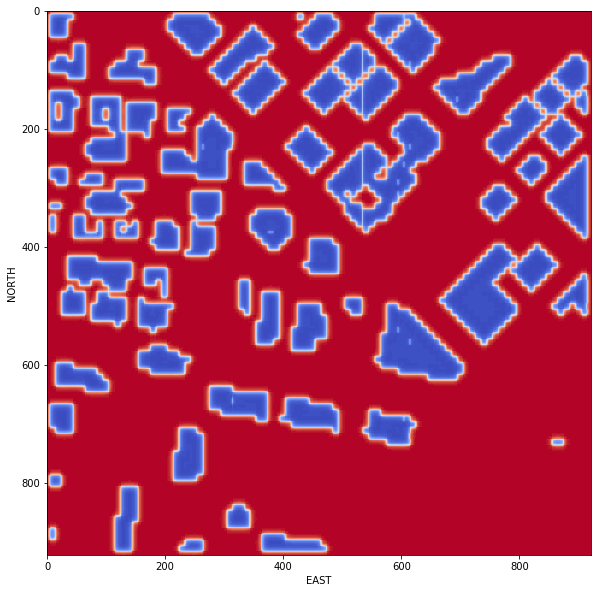

In [12]:
# Show field
draw_grid(gridr, cmap = 'coolwarm')

### Visualise both fields
*Display both energy fields overlayed to see the combined heuristic*

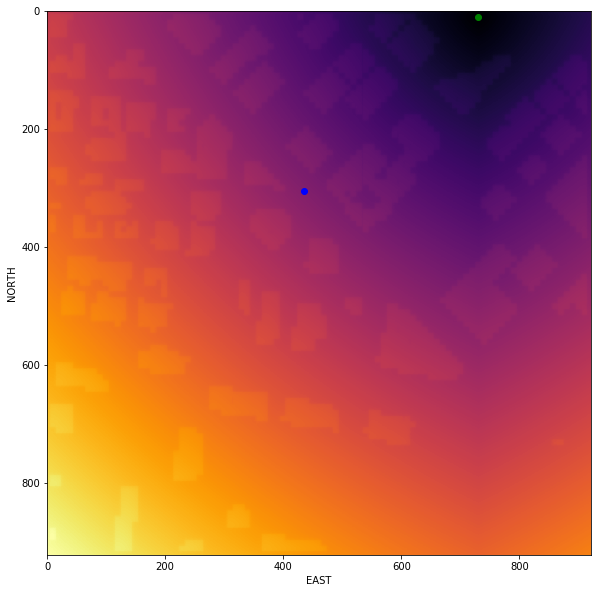

In [13]:
gridcombined = np.zeros_like(grid)
for i in range(len(grid)):
    for j in range(len(grid[0])):
        gridcombined[i, j] = (grida[i, j] - gridr[i, j]) # potential energy is the negative of the combined force value

draw_grid(gridcombined, cmap = 'inferno', start = start, goal = goal)

## Search algorithm

Explanation of the different cost functions are as follows:
* $c$ is the current cost
* $g$ is the cost function
* $a$ is the attraction function
* $r$ is the repulsion function

Then the new cost is $c_{new} = c + g() + h() + r()$.

The difference between $g$ and $a$ & $r$ is that $g$ models the cost of performing actions, irrespective of the environment, while $a$ and $r$ model the cost based on the environment, i.e., the distance to the goal and any neighbouring obstacles.

In [27]:
def e_star(grid, a, r, start, goal, jump_steps = [1], jump_weights = [1.0], weight = 0.1):

    path = []
    queue = PriorityQueue()
    queue.put((0, 0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[1]
        current_node = item[2]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            actions = valid_actions(grid, current_node)
            
            for (jump_step, jump_weight) in zip(jump_steps, jump_weights):
                for action in actions:
                    # get the tuple representation
                    da = action.delta
                    cost = action.cost * (jump_step * jump_weight)
                    next_node = (current_node[0] + da[0] * jump_step, \
                                 current_node[1] + da[1] * jump_step)
                    # calculate new cost, c + g()
                    new_cost = current_cost + cost
                    # calculate new heuristic, a() + r()
                    new_heuristic = (a(next_node) - r(next_node))

                    if next_node not in visited:
                        visited.add(next_node)
                        # switched sort order to use heuristic first for 10x speedup
                        queue.put((new_heuristic, new_cost * weight, next_node))

                        branch[next_node] = (new_cost, current_node, action, jump_step)
             
    path = []
    path_cost = 0
    
    if found:    
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2] * branch[n][3])
            n = branch[n][1]
        
        path.append(branch[n][2] * branch[n][3])
            
    return path[::-1], path_cost

In [53]:
import time

jump_steps = [1, 5, 10]
jump_weights = [1, 4.9, 9.8]
start = (304, 435)
goal = (750, 20)

def attractor(node):
    return attractive_force(node, goal, alpha = 1)

def repulsor(node):
    return repulsive_force(grid, node, beta = 100, boundary = 20)

t0 = time.time()
path, cost = e_star(grid, attractor, repulsor, start, goal, jump_steps = jump_steps, jump_weights = jump_weights, weight = 1.0)
etime = time.time()-t0

print('Energy* Search took {0} seconds, with cost = {1}'.format(etime, cost))
print(path, cost)

Found a path.
Energy* Search took 1.8370628356933594 seconds, with cost = 6643.637728526453
[(10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (0, -10, 1), (-1, -1, 1.4142135623730951), (0, -10, 1), (0, -10, 1), (0, -10, 1), (0, -10, 1), (0, -10, 1), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, 0, 1), (10, 0, 1), (10, 0, 1), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, 0, 1), (1, -1, 1.4142135623730951), (0, -1, 1), (10, 10, 1.4142135623730951), (10, -10, 1.4142135623730951), (10, 0, 1), (10, 0, 1), (10, -10, 1.4142135623730951), (5, -5, 1.4142135623730951), (0, -10, 1), (1, -1, 1.4142135623730951), (1, -1, 1.4142135623730951), (0, -10, 1), (1, 0, 1), (1, 0

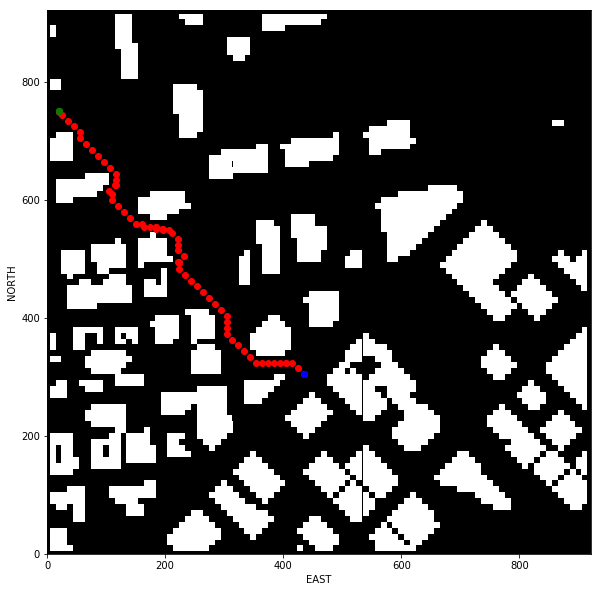

In [58]:
# S -> start, G -> goal, O -> obstacle
original = walkpath(grid, path, start, goal)
draw_grid(grid, cmap = 'gray', path = original, start = start, goal = goal)